## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

### Read calibration images and fill objpoints and imgpoints for calibration

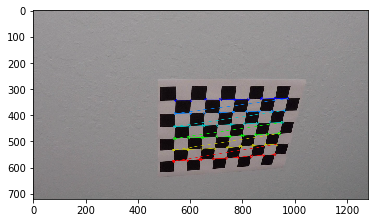

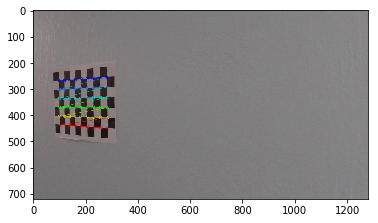

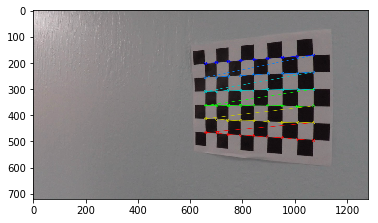

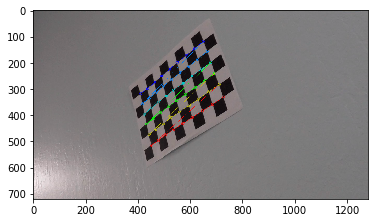

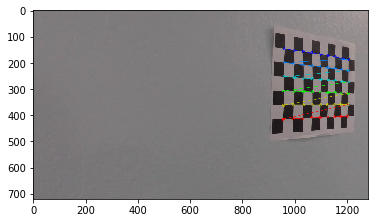

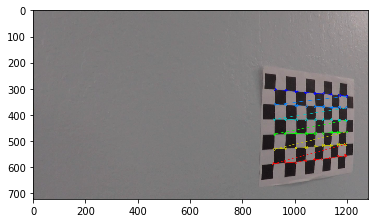

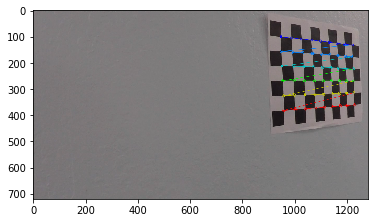

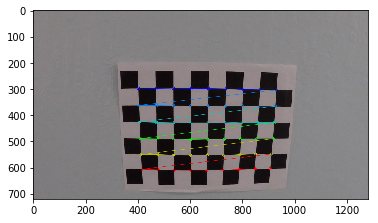

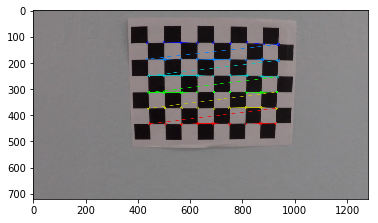

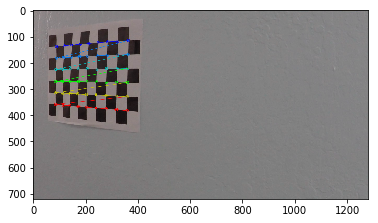

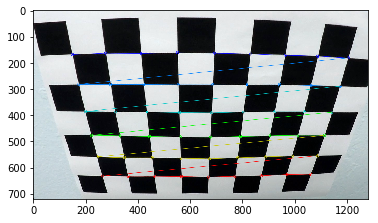

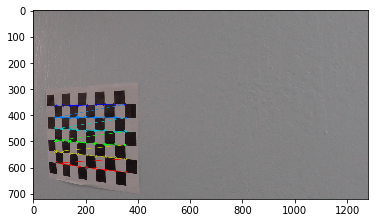

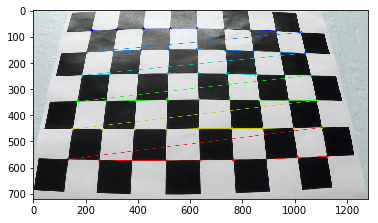

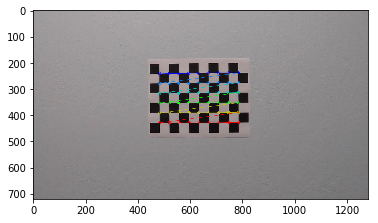

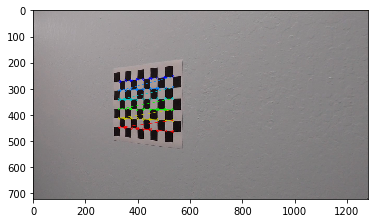

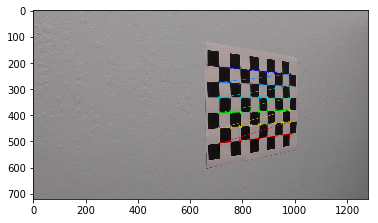

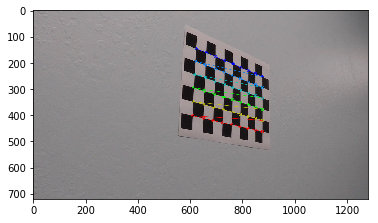

In [21]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []

images = glob.glob('./camera_cal/calibration*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        plt.imshow(img)
        plt.show()

### Calibrate camera and def undistort method for an image

In [173]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_2_imgs(img1, img2, title1, title2, file_path=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1, cmap='gray')
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(title2, fontsize=30)
    
    if file_path is not None:
        f.savefig('./writeup_imgs/' + file_path)

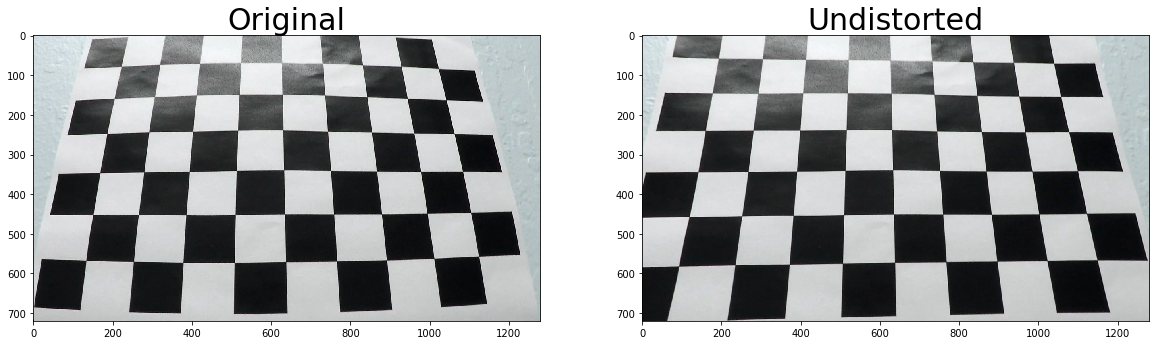

In [174]:
import pickle
import matplotlib.image as mpimg

img = cv2.imread('./camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("./camera_cal/dist_pickle.p", "wb"))

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

dst = undistort(img)
    
plot_2_imgs(img, dst, 'Original', 'Undistorted', 'undist.jpg')

---
## Next, I'll combine various thresholding operations to better detect lane lines

### Define and test color thresholding methods

In [175]:
def binary_thresh(img, thresh=(0, 255)):
    binary = np.zeros_like(img)
    binary[(img > thresh[0]) & (img <= thresh[1])] = 1
    return binary
    
# load test image
img = mpimg.imread('./test_images/test4.jpg')

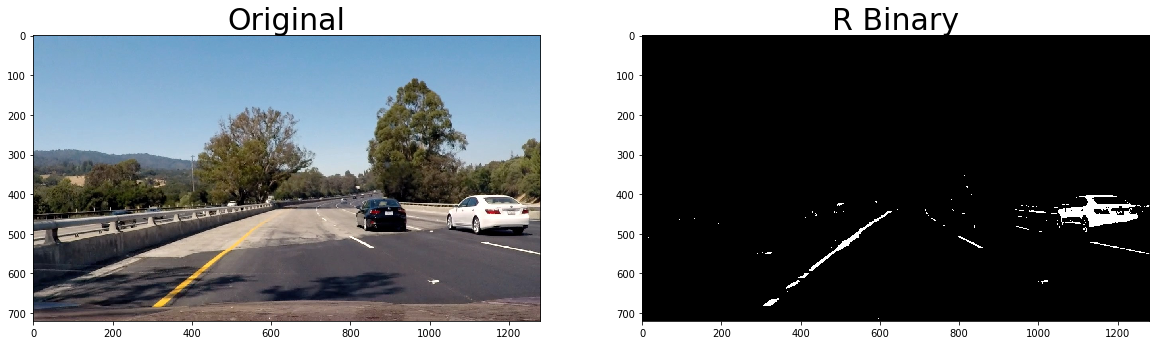

In [143]:
def r_binary(img, thresh=(225, 255)):
    r = img[:,:,0]
    r_bin = binary_thresh(r, thresh)
    return r_bin

# test and plot
des = r_binary(img)
plot_2_imgs(img, des, 'Original', 'R Binary', 'rbin.jpg')

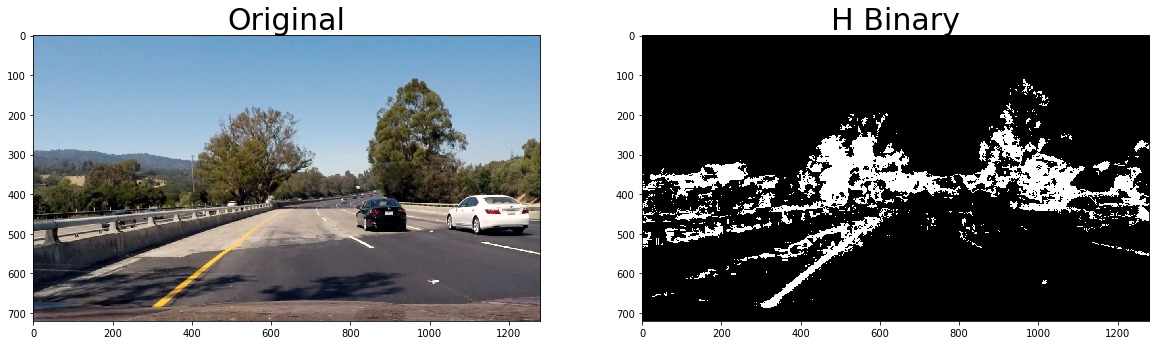

In [144]:
def h_binary(img, thresh=(15, 25)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    h_bin = binary_thresh(h, thresh)
    return h_bin

des = h_binary(img)
plot_2_imgs(img, des, 'Original', 'H Binary', 'hbin.jpg')

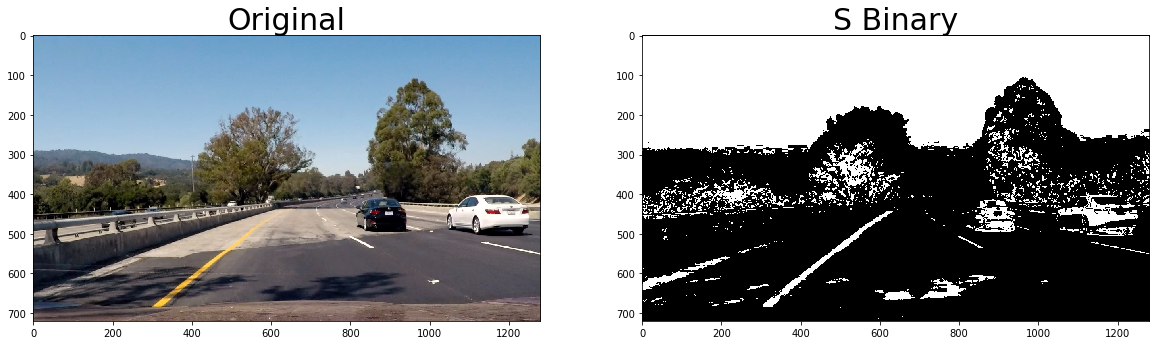

In [169]:
def s_binary(img, thresh=(100, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    s_bin = binary_thresh(s, thresh)
    return s_bin

des = s_binary(img)
plot_2_imgs(img, des, 'Original', 'S Binary', 'sbin.jpg')

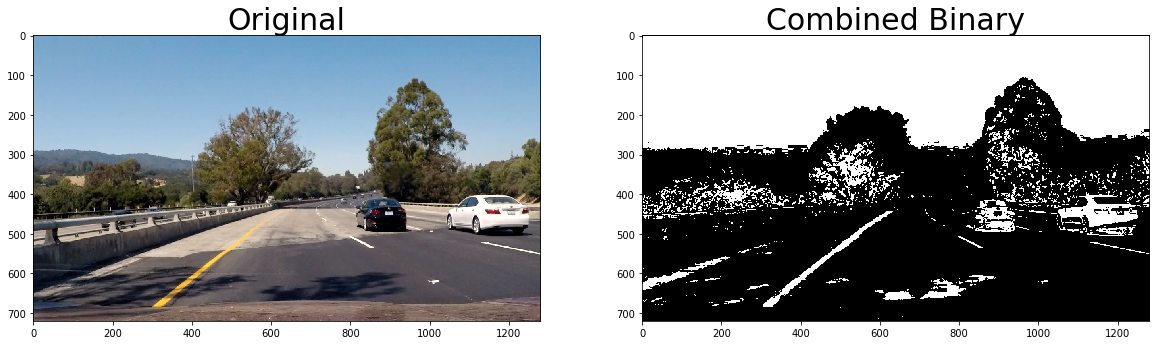

In [146]:
def combined_color_binary(img):
    s_bin = s_binary(img)
    r_bin = r_binary(img)
    
    combined = np.zeros_like(s_bin)
    combined[(s_bin==1) | (r_bin==1)] = 1
    return combined

des = combined_color_binary(img)
plot_2_imgs(img, des, 'Original', 'Combined Binary', 'comb_color.jpg')

### Define and test sobel thresholding methods

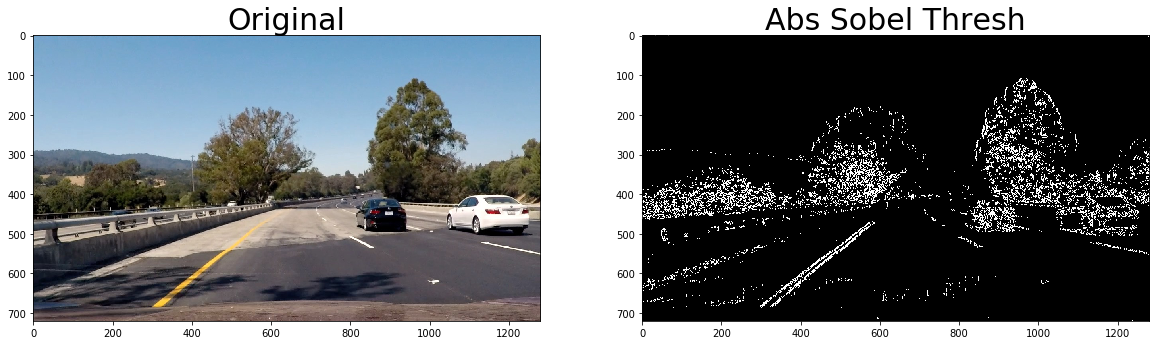

In [159]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100)):
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(cv2.Sobel(s, cv2.CV_64F, orient=='x', orient=='y', ksize=sobel_kernel))
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude is between thresh
    binary_output = binary_thresh(scaled_sobel, thresh)
    
    # Return this mask as your binary_output image
    return binary_output

des = abs_sobel_thresh(img)
plot_2_imgs(img, des, 'Original', 'Abs Sobel Thresh', 'abs_sobel_thresh.jpg')

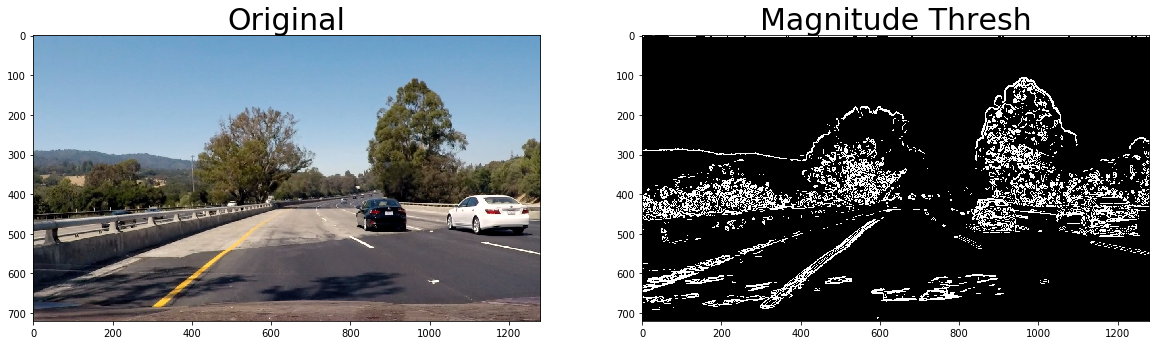

In [160]:
def mag_thresh(img, sobel_kernel=9, thresh=(30, 100)):
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(s, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(s, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude 
    mag = np.sqrt(sobelx**2 + sobely**2)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(mag)/255
    mag = (mag/scale_factor).astype(np.uint8)
    
    # Create a binary mask where mag thresholds are met
    binary_output = binary_thresh(mag, thresh)
    
    # Return this mask as your binary_output image
    return binary_output

des = mag_thresh(img)
plot_2_imgs(img, des, 'Original', 'Magnitude Thresh', 'mag_thresh.jpg')

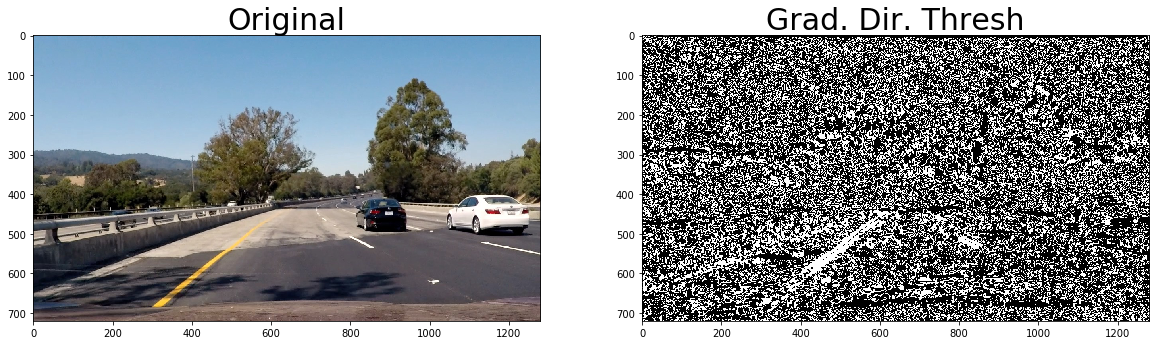

In [161]:
def dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3)):
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(s, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(s, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the x and y gradients
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # Create a binary mask where direction thresholds are met
    # Return this mask as your binary_output image
    binary_output = binary_thresh(absgraddir, thresh)
    
    return binary_output

des = dir_thresh(img)
plot_2_imgs(img, des, 'Original', 'Grad. Dir. Thresh', 'dir_thresh.jpg')

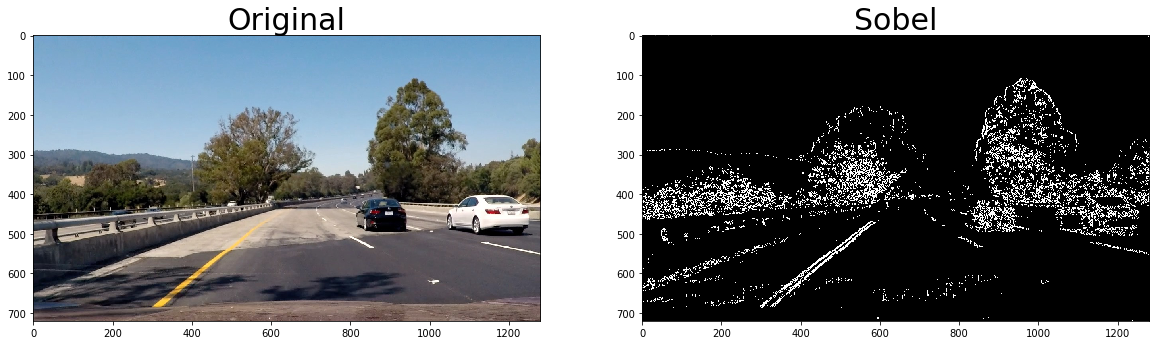

In [170]:
def combined_sobel_binary(img, sobel_kernel=3, sx_thresh=(20, 100), sy_thresh=(0, 255), m_thresh=(30, 100), d_thresh=(0.7, 1.3)):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=sobel_kernel, thresh=sx_thresh)
    mag_bin = mag_thresh(img, sobel_kernel=sobel_kernel, thresh=m_thresh)
    dir_bin = dir_thresh(img, sobel_kernel=sobel_kernel, thresh=d_thresh)
    
    combined = np.zeros_like(dir_bin)
    combined[((gradx==1)) | ((mag_bin==1)&(dir_bin==1))] = 1
    return combined

# test and plot
ksize = 3
img = mpimg.imread('./test_images/test4.jpg')
des = combined_sobel_binary(img, 
                     sobel_kernel=ksize)

plot_2_imgs(img, des, 'Original', 'Sobel', 'combined_sobel.jpg')

### Combine thresholding methods into single combined threshold pipeline

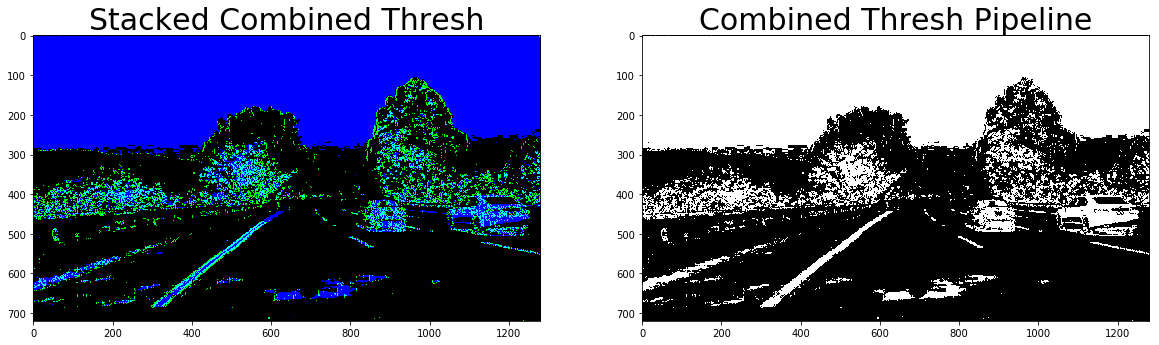

In [176]:
def combined_thresh_stacked_output(img):
    img = np.copy(img)
    
    sobel_bin = combined_sobel_binary(img)
    color_bin = combined_color_binary(img)
    
    binary_output = np.dstack((np.zeros_like(sobel_bin), sobel_bin, color_bin))
    return binary_output

def combined_threshold_pipeline(img):
    img = np.copy(img)
    
    sobel_bin = combined_sobel_binary(img)
    color_bin = combined_color_binary(img)
    
    binary_output = np.zeros_like(sobel_bin)
    binary_output[(sobel_bin==1) | (color_bin==1)] = 1
    return binary_output

color_out = combined_thresh_stacked_output(img)
binary_out = combined_threshold_pipeline(img)

# Plot the result
plot_2_imgs(color_out, binary_out, 'Stacked Combined Thresh', 'Combined Thresh Pipeline', 'comb_thresh_pipeline.jpg')

---
## Next, I'll use perspecitve transform to give us a bird's eye view of the lane lines

### Investigate image of staright lane lines to define four points depicting a trapezoid region for transform

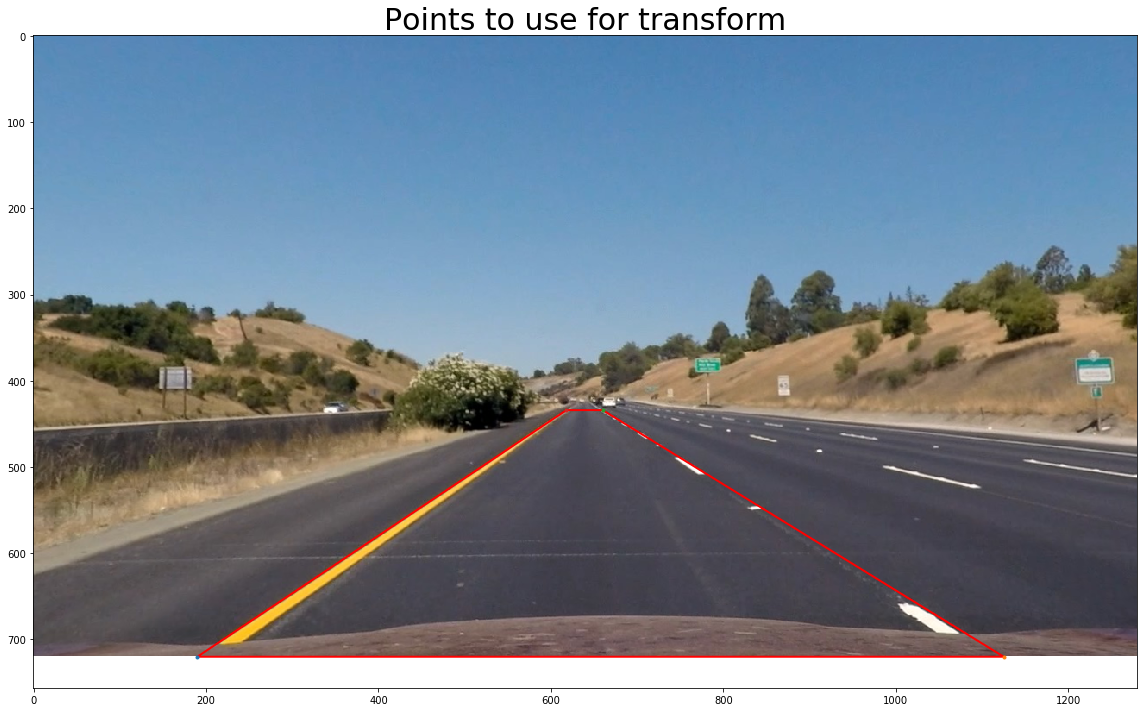

In [216]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline

pt1 = (190, 720)
pt2 = (1125, 720)
pt3 = (660, 434)
pt4 = (618, 434)
pts = [pt1,pt2,pt3,pt4]

codes = [Path.MOVETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.CLOSEPOLY,
        ]

path = Path([pt1,pt2,pt3,pt4,pt1],codes)

img = undistort(mpimg.imread('./test_images/straight_lines1.jpg'))

f, ax = plt.subplots(figsize=(20,10))
ax.imshow(img)
ax.plot(pt1[0], pt1[1], '.')
ax.plot(pt2[0], pt2[1], '.')
ax.plot(pt3[0], pt3[1], '.')
ax.plot(pt4[0], pt4[1], '.')
patch = patches.PathPatch(path, facecolor='none', edgecolor='red', lw=2)
ax.add_patch(patch)
ax.set_title('Points to use for transform', fontsize=30)

f.savefig('./writeup_imgs/region_of_interest.jpg')

f.tight_layout()

In [217]:
def transform(img, pts, offset=(100,0)):
    undist = undistort(img)
    img_size = (img.shape[1], img.shape[0])
    print (img_size)
    
transform(img,pts)

(1280, 720)
